<a href="https://colab.research.google.com/github/qmeng222/MNIST-Playground/blob/main/optimizers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Task:**

---
Comparison of optimizers by learning rates:
1.   test accuracy (ave. last 10 epochs) vs. learning rates
2.   optimizers (SGD, RMSprop, Adam)
3.   learning rates (.0001 to .1 in 6 log steps)

In [ ]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

In [ ]:
# import dataset (comes with colab!)
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',') # numpy array

# extract labels and drop labels from data:
labels = data[:,0] # extract
data   = data[:,1:] # drop

# normalize (both train & test) data to [0 1]:
dataNorm = data / np.max(data)

In [ ]:
# Step 1: convert to PyTorch tensors
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long()

# Step 2: use scikitlearn to split the data (still tensors):
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)
print(train_data.shape,test_data.shape, train_labels.shape,test_labels.shape)

# Step 3: PyTorch tensors -> PyTorch TensorDataset objects:
# combine data and label tensors into a single dataset object
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: PyTorch TensorDataset objects -> PyTorch dataloader objects
# shuffle the data to help model generalize better
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

torch.Size([18000, 784]) torch.Size([2000, 784]) torch.Size([18000]) torch.Size([2000])


In [ ]:
def createTheMNISTNet(optimizerAlgo,learningrate):

  # model class:
  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)

      ### hidden layers
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return self.output(x) # NOTE: no softmax is needed with CEL

  # create a model instance:
  net = mnistNet()

  # loss function
  lossfun = nn.CrossEntropyLoss() # CEL internally computes log-softmax

  # optimizer
  # dynamically retrieve an attribute from the torch.optim module based on the value optimizerAlgo:
  optifun = getattr( torch.optim,optimizerAlgo )
  optimizer = optifun(net.parameters(),lr=learningrate)

  return net,lossfun,optimizer

In [ ]:
# a function that trains the model

def function2trainTheModel(optimizerAlgo,learningrate):

  # number of epochs
  numepochs = 100

  # create a new model
  net,lossfun,optimizer = createTheMNISTNet(optimizerAlgo,learningrate)

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)

    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net

In [ ]:
# note: this experiment takes ~30 mins

# variables to loop over
learningRates = np.logspace(np.log10(.0001),np.log10(.1),6)
optimTypes = ['SGD','RMSprop','Adam']

# initialize performance matrix
finalPerformance = np.zeros((len(learningRates),len(optimTypes)))

# now for the experiment!
for idx_o,opto in enumerate(optimTypes):
  for idx_l,lr in enumerate(learningRates):
    trainAcc,testAcc,losses,net = function2trainTheModel(opto,lr)
    finalPerformance[idx_l,idx_o] = np.mean(testAcc[-10:])

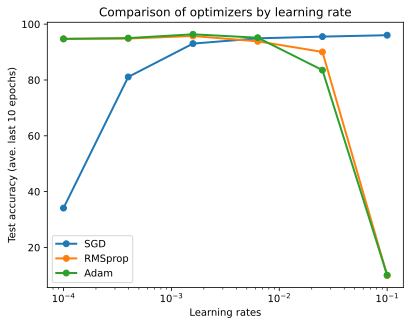

In [ ]:
# plot the results!
plt.plot(learningRates,finalPerformance,'o-',linewidth=2)
plt.legend(optimTypes)
plt.xscale('log')
plt.xlabel('Learning rates')
plt.ylabel('Test accuracy (ave. last 10 epochs)')
plt.title('Comparison of optimizers by learning rate')
plt.show()

**Observations:**


---
1.   In this data set, SGD does well for large learning rates.
2.   And the RMSprop and Adam actually do well for small learning rates, and do poorly for large learning rates, as RMSprop and Adam have built in dynamic learning rates.
3.   Therefore Adam and Rmsprop tend to do better when you initialize the learning rate to something small.

